In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# change to your working directory
%cd "/content/drive/MyDrive/shared folder/Master_Thesis" 
#%cd "/content/drive/MyDrive/shared_folder/Master_Thesis"
#%cd "/content/drive/MyDrive/shared_folder/Master_Thesis"

/content/drive/.shortcut-targets-by-id/1lHcON5EHJDerZlJ2mPUGsY4w6iFLBKs5/shared_folder/Master_Thesis


# Setup

In [3]:
## Import Libraries
from __future__ import absolute_import, division, print_function, unicode_literals
import os, shutil, random, glob, cv2
import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Reshape, GlobalMaxPool2D, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import PIL.Image
import sklearn.model_selection as sklrn
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from termcolor import colored
import statistics
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from sklearn import metrics
from keras.models import Sequential
from keras import layers
from keras.layers import GlobalMaxPooling2D
from keras import applications
from keras import optimizers
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, ResNet50V2
from  keras.models import Model
import tensorflow as tf
import datetime
import time
from keras import regularizers
from collections import Counter

In [4]:
## Define Constants
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
BATCH_SIZE = 128

In [5]:
# set outlay of dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


# Loading Model

**Baseline Model -VGG16**

-learning rate: 1e-4

-optimizer: Adam

-batch size: 128

-epoch: 20

-image size:256*256

In [9]:
# load model
model_VGG16 = tf.keras.models.load_model("./Model/AU_Model/AU_model_VGG.h5")

**Baseline Model -ResNet50V2**

-learning rate: 1e-3

-optimizer: Adam

-batch size: 128

-epoch: 15

-image size:256*256

In [ ]:
# load model
model_resnet50V2 = tf.keras.models.load_model("./Model/AU_Model/AU_model_Resnet50V2.h5")

**Baseline Model -InceptionV3**

-learning rate: 1e-4

-optimizer: Adam

-batch size: 128

-epoch: 20

-image size:256*256

In [ ]:
# load model
model_V3 = tf.keras.models.load_model("./Model/AU_Model/AU_model_InceptionV3.h5")

# Configuration

## Configuration for Predictor




In [ ]:
def imagenet_processing(image):
    image = image/255
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    for i in range(3):
        image[:,:,i] -= mean[i]
        image[:,:,i] /= std[i]
    return image

In [ ]:
def test_pred_patch(folderdir, model):
    filelist=sorted(glob.glob(os.path.join(folderdir, "*.*")))
    file_name=[]
    file_lables=[]
    file_predict=[]
    for file in filelist: 
        filename=file.split('/')[-1]
        filelabels=file.split('/')[-1]
        filelabels=filelabels.split('-')[0]
        file_name.append(filename)
        file_lables.append(filelabels)
        img = tf.keras.utils.load_img(file, target_size=IMAGE_SIZE)
        x = tf.keras.utils.img_to_array(img)
        x = imagenet_processing(x)
        x = np.expand_dims(x, axis=0)
        preds = model.predict(x)
        preds=np.argmax(preds,axis=1)
        print(filename, ":" , preds[0])
        file_predict.append(preds[0])

    df_test_pred = pd.DataFrame({
        'filename': file_name,
        'filelabels': file_lables,
        'predict': file_predict
    })

    return df_test_pred


## Configuration for Prediction Result

In [ ]:
def prediction_show(df_testset_pred, csv_save_path,modelname):
    df_testset_pred["predict1"] = df_testset_pred["predict"].replace({0: 'aca', 1: 'n', 2: 'scc', 3:'none'})
    df_testset_pred["filelabels1"] = df_testset_pred["filelabels"].replace({'aca':0, 'n': 1, 'scc': 2}) 

    # Check if any scc=aca , if yes, remove it
    x = pd.unique(df_testset_pred['predict'])
    x = x.tolist()
    #print(pd.unique(df_testset_pred['predict']))
    #print("Before:",len(df_testset_pred['predict']))
    #df_testset_pred = df_testset_pred[df_testset_pred.predict < 3]
    #print("After:",len(df_testset_pred['predict']))
    df_testset_pred.to_csv(csv_save_path)  # set
    sns.set_style("whitegrid")
    ax = sns.heatmap(metrics.confusion_matrix(df_testset_pred["filelabels"], df_testset_pred["predict1"]), annot=True, 
                 cmap='Blues',
                 fmt="d")
    ax.set_title(f'{modelname}\nConfusion Matrix with labels\n');
    ax.set_xlabel('\nPredicted Label')
    ax.set_ylabel('Actual Label')
    if len(x) == 3:
        ax.xaxis.set_ticklabels(['aca', 'n','scc'])
        ax.yaxis.set_ticklabels(['aca', 'n','scc'])
    elif len(x) == 2:
        if x[0]*x[1] > 0:
            ax.xaxis.set_ticklabels(['n','scc'])
            ax.yaxis.set_ticklabels(['n','scc'])
        elif 1 in x:
            ax.xaxis.set_ticklabels(['aca', 'n'])
            ax.yaxis.set_ticklabels(['aca', 'n'])
        else:
            ax.xaxis.set_ticklabels(['aca','scc'])
            ax.yaxis.set_ticklabels(['aca','scc'])
    else:
        if 0 in x:
            ax.xaxis.set_ticklabels(['aca'])
            ax.yaxis.set_ticklabels(['aca'])
        elif 1 in x:
            ax.xaxis.set_ticklabels(['n'])
            ax.yaxis.set_ticklabels(['n'])
        else:
            ax.xaxis.set_ticklabels(['scc'])
            ax.yaxis.set_ticklabels(['scc'])
    plt.show()
    print(colored(modelname, attrs=['bold']))
    print("Accuracy: {0:.2f}".format(metrics.accuracy_score(df_testset_pred["filelabels"], df_testset_pred["predict1"])*100),"%")
    print("F1 Score: {0:.3f}".format(metrics.f1_score(df_testset_pred["filelabels"], df_testset_pred["predict1"], average = 'weighted')))
    print("Recall: {0:.3f}".format(metrics.recall_score(df_testset_pred["filelabels"], df_testset_pred["predict1"], average = 'weighted')))
    print("Precision: {0:.3f}".format(metrics.precision_score(df_testset_pred["filelabels1"], df_testset_pred["predict"], average = 'weighted')))
    print("Area Under the ROC: {0:.3f}".format(metrics.roc_auc_score(df_testset_pred["filelabels1"], df_testset_pred["predict"], average = 'weighted',  multi_class= 'ovr')))

# Prediction

## Unprocessed Images


### VGG

In [ ]:
df_test_pred_vgg_HSV = test_pred_patch(folderdir="./Images/TCGA_patch/patch/patch_test/", model=model_VGG16)

Streaming output truncated to the last 5000 lines.
aca-69-7980-01Z-00-DX1-35_32_.jpeg : 1
aca-69-7980-01Z-00-DX1-35_33_.jpeg : 0
aca-69-7980-01Z-00-DX1-35_34_.jpeg : 0
aca-69-7980-01Z-00-DX1-35_35_.jpeg : 0
aca-69-7980-01Z-00-DX1-36_32_.jpeg : 0
aca-69-7980-01Z-00-DX1-36_34_.jpeg : 2
aca-69-7980-01Z-00-DX1-37_21_.jpeg : 1
aca-69-7980-01Z-00-DX1-37_22_.jpeg : 1
aca-69-7980-01Z-00-DX1-37_24_.jpeg : 1
aca-69-7980-01Z-00-DX1-37_27_.jpeg : 1
aca-69-7980-01Z-00-DX1-37_28_.jpeg : 1
aca-69-7980-01Z-00-DX1-37_33_.jpeg : 2
aca-69-7980-01Z-00-DX1-38_20_.jpeg : 1
aca-69-7980-01Z-00-DX1-38_22_.jpeg : 1
aca-69-7980-01Z-00-DX1-38_33_.jpeg : 2
aca-69-7980-01Z-00-DX1-39_17_.jpeg : 1
aca-69-7980-01Z-00-DX1-39_18_.jpeg : 1
aca-69-7980-01Z-00-DX1-39_20_.jpeg : 1
aca-69-7980-01Z-00-DX1-39_27_.jpeg : 1
aca-69-7980-01Z-00-DX1-39_28_.jpeg : 1
aca-69-7980-01Z-00-DX1-39_29_.jpeg : 0
aca-69-7980-01Z-00-DX1-39_30_.jpeg : 1
aca-69-7980-01Z-00-DX1-40_17_.jpeg : 1
aca-69-7980-01Z-00-DX1-40_23_.jpeg : 1
aca-69-7980-0

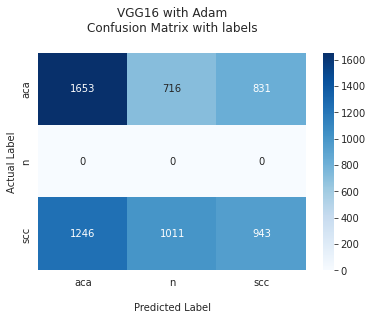

VGG16 with Adam
Accuracy: 40.56 %
F1 Score: 0.461
Recall: 0.406
Precision: 0.551
Area Under the ROC: 0.556


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
prediction_show(df_test_pred_vgg_HSV, 
                csv_save_path="./Code/Model_prediction/HSV_vgg_Adam_p15_e-3_b128_2500i_s256_prediction_patch.csv",
                modelname='VGG16 with Adam')

### ResNet50V2

In [ ]:
df_test_pred_resnet_HSV = test_pred_patch(folderdir="./Images/TCGA_patch/patch/patch_test/", model=model_resnet50V2)

Streaming output truncated to the last 5000 lines.
aca-69-7980-01Z-00-DX1-35_32_.jpeg : 2
aca-69-7980-01Z-00-DX1-35_33_.jpeg : 0
aca-69-7980-01Z-00-DX1-35_34_.jpeg : 2
aca-69-7980-01Z-00-DX1-35_35_.jpeg : 0
aca-69-7980-01Z-00-DX1-36_32_.jpeg : 2
aca-69-7980-01Z-00-DX1-36_34_.jpeg : 2
aca-69-7980-01Z-00-DX1-37_21_.jpeg : 0
aca-69-7980-01Z-00-DX1-37_22_.jpeg : 0
aca-69-7980-01Z-00-DX1-37_24_.jpeg : 0
aca-69-7980-01Z-00-DX1-37_27_.jpeg : 0
aca-69-7980-01Z-00-DX1-37_28_.jpeg : 2
aca-69-7980-01Z-00-DX1-37_33_.jpeg : 0
aca-69-7980-01Z-00-DX1-38_20_.jpeg : 0
aca-69-7980-01Z-00-DX1-38_22_.jpeg : 0
aca-69-7980-01Z-00-DX1-38_33_.jpeg : 0
aca-69-7980-01Z-00-DX1-39_17_.jpeg : 0
aca-69-7980-01Z-00-DX1-39_18_.jpeg : 0
aca-69-7980-01Z-00-DX1-39_20_.jpeg : 0
aca-69-7980-01Z-00-DX1-39_27_.jpeg : 0
aca-69-7980-01Z-00-DX1-39_28_.jpeg : 0
aca-69-7980-01Z-00-DX1-39_29_.jpeg : 0
aca-69-7980-01Z-00-DX1-39_30_.jpeg : 0
aca-69-7980-01Z-00-DX1-40_17_.jpeg : 2
aca-69-7980-01Z-00-DX1-40_23_.jpeg : 0
aca-69-7980-0

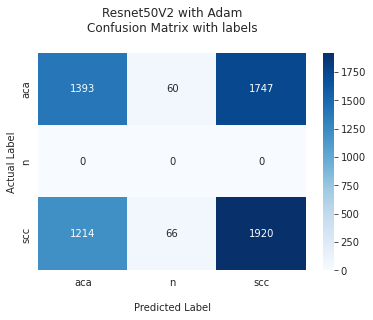

Resnet50V2 with Adam
Accuracy: 51.77 %
F1 Score: 0.519
Recall: 0.518
Precision: 0.529
Area Under the ROC: 0.528


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
prediction_show(df_test_pred_resnet_HSV, 
                csv_save_path="./Code/Model_prediction/HSV_resnet50V2_Adam_p15_e-3_b128_2500i_s256_prediction_patch.csv",
                modelname='Resnet50V2 with Adam')

### InceptionV3

In [ ]:
df_test_pred_V3_HSV = test_pred_patch(folderdir="./Images/TCGA_patch/patch/patch_test/", model=model_V3)

Streaming output truncated to the last 5000 lines.
aca-69-7980-01Z-00-DX1-35_32_.jpeg : 0
aca-69-7980-01Z-00-DX1-35_33_.jpeg : 2
aca-69-7980-01Z-00-DX1-35_34_.jpeg : 0
aca-69-7980-01Z-00-DX1-35_35_.jpeg : 0
aca-69-7980-01Z-00-DX1-36_32_.jpeg : 2
aca-69-7980-01Z-00-DX1-36_34_.jpeg : 2
aca-69-7980-01Z-00-DX1-37_21_.jpeg : 0
aca-69-7980-01Z-00-DX1-37_22_.jpeg : 1
aca-69-7980-01Z-00-DX1-37_24_.jpeg : 0
aca-69-7980-01Z-00-DX1-37_27_.jpeg : 0
aca-69-7980-01Z-00-DX1-37_28_.jpeg : 0
aca-69-7980-01Z-00-DX1-37_33_.jpeg : 0
aca-69-7980-01Z-00-DX1-38_20_.jpeg : 2
aca-69-7980-01Z-00-DX1-38_22_.jpeg : 0
aca-69-7980-01Z-00-DX1-38_33_.jpeg : 0
aca-69-7980-01Z-00-DX1-39_17_.jpeg : 1
aca-69-7980-01Z-00-DX1-39_18_.jpeg : 1
aca-69-7980-01Z-00-DX1-39_20_.jpeg : 0
aca-69-7980-01Z-00-DX1-39_27_.jpeg : 0
aca-69-7980-01Z-00-DX1-39_28_.jpeg : 0
aca-69-7980-01Z-00-DX1-39_29_.jpeg : 2
aca-69-7980-01Z-00-DX1-39_30_.jpeg : 0
aca-69-7980-01Z-00-DX1-40_17_.jpeg : 2
aca-69-7980-01Z-00-DX1-40_23_.jpeg : 0
aca-69-7980-0

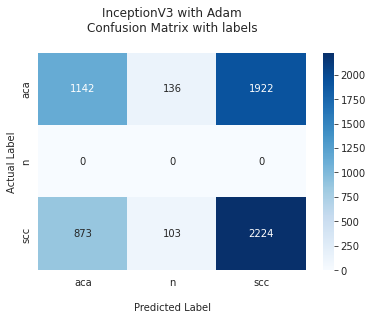

InceptionV3 with Adam
Accuracy: 52.59 %
F1 Score: 0.522
Recall: 0.526
Precision: 0.552
Area Under the ROC: 0.547


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
prediction_show(df_test_pred_V3_HSV, 
                csv_save_path="./Code/Model_prediction/HSV_V3_Adam_p15_e-3_b128_2500i_s256_prediction_patch.csv",
                modelname='InceptionV3 with Adam')

## Cyclegan-processed Images

### VGG

In [ ]:
df_test_pred_vgg_HSV_cycles = test_pred_patch(folderdir="./Images/TCGA_patch/patch_cyclegan/patch_cyclegan_test/", model=model_VGG16)

Streaming output truncated to the last 5000 lines.
aca-69-7980-01Z-00-DX1_214.jpg : 2
aca-69-7980-01Z-00-DX1_219.jpg : 1
aca-69-7980-01Z-00-DX1_222.jpg : 1
aca-69-7980-01Z-00-DX1_224.jpg : 2
aca-69-7980-01Z-00-DX1_225.jpg : 1
aca-69-7980-01Z-00-DX1_23.jpg : 0
aca-69-7980-01Z-00-DX1_231.jpg : 2
aca-69-7980-01Z-00-DX1_232.jpg : 2
aca-69-7980-01Z-00-DX1_233.jpg : 2
aca-69-7980-01Z-00-DX1_235.jpg : 2
aca-69-7980-01Z-00-DX1_237.jpg : 1
aca-69-7980-01Z-00-DX1_238.jpg : 0
aca-69-7980-01Z-00-DX1_239.jpg : 0
aca-69-7980-01Z-00-DX1_241.jpg : 0
aca-69-7980-01Z-00-DX1_244.jpg : 2
aca-69-7980-01Z-00-DX1_246.jpg : 0
aca-69-7980-01Z-00-DX1_247.jpg : 2
aca-69-7980-01Z-00-DX1_248.jpg : 2
aca-69-7980-01Z-00-DX1_249.jpg : 1
aca-69-7980-01Z-00-DX1_25.jpg : 1
aca-69-7980-01Z-00-DX1_250.jpg : 1
aca-69-7980-01Z-00-DX1_256.jpg : 2
aca-69-7980-01Z-00-DX1_257.jpg : 1
aca-69-7980-01Z-00-DX1_258.jpg : 2
aca-69-7980-01Z-00-DX1_259.jpg : 2
aca-69-7980-01Z-00-DX1_26.jpg : 1
aca-69-7980-01Z-00-DX1_260.jpg : 2
aca-69-

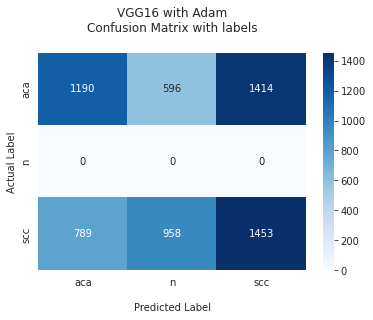

VGG16 with Adam
Accuracy: 41.30 %
F1 Score: 0.469
Recall: 0.413
Precision: 0.554
Area Under the ROC: 0.539


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
prediction_show(df_test_pred_vgg_HSV_cycles, 
                csv_save_path="./Code/Model_prediction/HSV_vgg_Adam_p15_e-3_b128_2500i_s256_prediction_patch_cyclegan.csv",
                modelname='VGG16 with Adam')

### ResNet50V2

In [ ]:
df_test_pred_resnet__HSVcyclegan = test_pred_patch(folderdir="./Images/TCGA_patch/patch_cyclegan/patch_cyclegan_test/", model=model_resnet50V2)

Streaming output truncated to the last 5000 lines.
aca-69-7980-01Z-00-DX1_214.jpg : 2
aca-69-7980-01Z-00-DX1_219.jpg : 1
aca-69-7980-01Z-00-DX1_222.jpg : 0
aca-69-7980-01Z-00-DX1_224.jpg : 2
aca-69-7980-01Z-00-DX1_225.jpg : 2
aca-69-7980-01Z-00-DX1_23.jpg : 2
aca-69-7980-01Z-00-DX1_231.jpg : 2
aca-69-7980-01Z-00-DX1_232.jpg : 2
aca-69-7980-01Z-00-DX1_233.jpg : 0
aca-69-7980-01Z-00-DX1_235.jpg : 2
aca-69-7980-01Z-00-DX1_237.jpg : 1
aca-69-7980-01Z-00-DX1_238.jpg : 0
aca-69-7980-01Z-00-DX1_239.jpg : 2
aca-69-7980-01Z-00-DX1_241.jpg : 2
aca-69-7980-01Z-00-DX1_244.jpg : 2
aca-69-7980-01Z-00-DX1_246.jpg : 2
aca-69-7980-01Z-00-DX1_247.jpg : 2
aca-69-7980-01Z-00-DX1_248.jpg : 2
aca-69-7980-01Z-00-DX1_249.jpg : 1
aca-69-7980-01Z-00-DX1_25.jpg : 0
aca-69-7980-01Z-00-DX1_250.jpg : 2
aca-69-7980-01Z-00-DX1_256.jpg : 2
aca-69-7980-01Z-00-DX1_257.jpg : 0
aca-69-7980-01Z-00-DX1_258.jpg : 2
aca-69-7980-01Z-00-DX1_259.jpg : 0
aca-69-7980-01Z-00-DX1_26.jpg : 0
aca-69-7980-01Z-00-DX1_260.jpg : 2
aca-69-

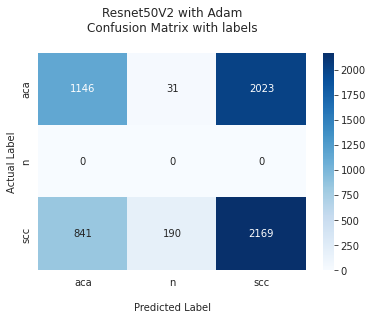

Resnet50V2 with Adam
Accuracy: 51.80 %
F1 Score: 0.514
Recall: 0.518
Precision: 0.547
Area Under the ROC: 0.532


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
prediction_show(df_test_pred_resnet__HSVcyclegan, 
                csv_save_path="./Code/Model_prediction/HSV_resnet50V2_Adam_p15_e-3_b128_2500i_s256_prediction_patch_clegan.csv",
                modelname='Resnet50V2 with Adam')

### InceptionV3

In [ ]:
df_test_pred_V3__HSVcyclegan = test_pred_patch(folderdir="./Images/TCGA_patch/patch_cyclegan/patch_cyclegan_test/", model=model_V3)

Streaming output truncated to the last 5000 lines.
aca-69-7980-01Z-00-DX1_214.jpg : 2
aca-69-7980-01Z-00-DX1_219.jpg : 1
aca-69-7980-01Z-00-DX1_222.jpg : 1
aca-69-7980-01Z-00-DX1_224.jpg : 2
aca-69-7980-01Z-00-DX1_225.jpg : 2
aca-69-7980-01Z-00-DX1_23.jpg : 1
aca-69-7980-01Z-00-DX1_231.jpg : 2
aca-69-7980-01Z-00-DX1_232.jpg : 2
aca-69-7980-01Z-00-DX1_233.jpg : 2
aca-69-7980-01Z-00-DX1_235.jpg : 2
aca-69-7980-01Z-00-DX1_237.jpg : 2
aca-69-7980-01Z-00-DX1_238.jpg : 0
aca-69-7980-01Z-00-DX1_239.jpg : 2
aca-69-7980-01Z-00-DX1_241.jpg : 0
aca-69-7980-01Z-00-DX1_244.jpg : 0
aca-69-7980-01Z-00-DX1_246.jpg : 0
aca-69-7980-01Z-00-DX1_247.jpg : 2
aca-69-7980-01Z-00-DX1_248.jpg : 2
aca-69-7980-01Z-00-DX1_249.jpg : 1
aca-69-7980-01Z-00-DX1_25.jpg : 2
aca-69-7980-01Z-00-DX1_250.jpg : 2
aca-69-7980-01Z-00-DX1_256.jpg : 2
aca-69-7980-01Z-00-DX1_257.jpg : 2
aca-69-7980-01Z-00-DX1_258.jpg : 2
aca-69-7980-01Z-00-DX1_259.jpg : 2
aca-69-7980-01Z-00-DX1_26.jpg : 2
aca-69-7980-01Z-00-DX1_260.jpg : 2
aca-69-

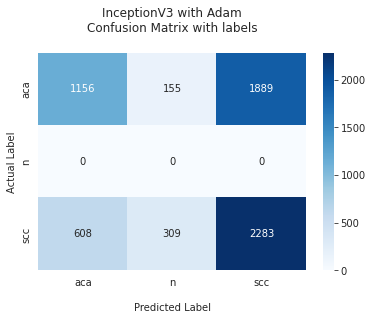

InceptionV3 with Adam
Accuracy: 53.73 %
F1 Score: 0.543
Recall: 0.537
Precision: 0.601
Area Under the ROC: 0.574


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
prediction_show(df_test_pred_V3__HSVcyclegan, 
                csv_save_path="./Code/Model_prediction/HSV_V3_Adam_p15_e-3_b128_2500i_s256_prediction_patch_cycles.csv",
                modelname='InceptionV3 with Adam')